In [1]:
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
plt.style.use('ggplot') 
%matplotlib inline

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate demographic data and data concerning hospital and ICU stays for patients diagnosed with sepsis. The query was exported from Porticoto the file ADMISSIONS_ICUSTAY_SEPSIS.csv. The data was read into a pandas dataframe lab_events 


In [2]:
data = pd.DataFrame.from_csv('SEPSIS_LABEVENTS_FIRST_py.csv')
data.head()

,hadm_id,icustay_id,mort_icu,mort_hosp,diagnosis,aniongap_1st,albumin_1st,bicarbonate_1st,bilirubin_1st,creatinine_1st,...,magnesium_1st,phosphate_1st,platelet_1st,potassium_1st,ptt_1st,inr_1st,pt_1st,sodium_1st,bun_1st,wbc_1st
subject_id,,,,,,,,,,,,,,,,,,,,,
21,111970,216859,1,1,SEPSIS,19.0,2.1,23.0,0.3,4.2,...,1.5,4.4,275.0,3.8,31.7,1.7,18.1,137.0,49.0,30.5
94,183686,229012,0,0,SEPSIS,13.0,NaN,23.0,1.4,0.6,...,1.4,2.1,162.0,2.5,31.0,1.0,12.0,132.0,8.0,6.0
157,107880,264885,0,0,SEPSIS,22.0,NaN,20.0,0.6,0.8,...,2.3,4.4,255.0,4.9,30.1,1.2,13.3,135.0,15.0,52.0
166,128219,271863,1,1,SEPSIS,19.0,NaN,24.0,NaN,0.8,...,NaN,NaN,341.0,3.7,22.8,1.2,13.5,142.0,20.0,16.5
188,191517,278679,0,0,SEPSIS,14.0,2.9,17.0,1.8,2.4,...,1.0,3.3,266.0,5.0,32.7,1.2,13.7,133.0,31.0,16.7


In [10]:
data.dtypes

hadm_id              int64
icustay_id           int64
mort_icu             int64
mort_hosp            int64
diagnosis           object
aniongap_1st       float64
albumin_1st        float64
bicarbonate_1st    float64
bilirubin_1st      float64
creatinine_1st     float64
chloride_1st       float64
glucose_1st        float64
hematocrit_1st     float64
hemoglobin_1st     float64
lactate_1st        float64
magnesium_1st      float64
phosphate_1st      float64
platelet_1st       float64
potassium_1st      float64
ptt_1st            float64
inr_1st            float64
pt_1st             float64
sodium_1st         float64
bun_1st            float64
wbc_1st            float64
dtype: object

In [3]:
cols = list(data.columns)
print cols

['hadm_id', 'icustay_id', 'mort_icu', 'mort_hosp', 'diagnosis', 'aniongap_1st', 'albumin_1st', 'bicarbonate_1st', 'bilirubin_1st', 'creatinine_1st', 'chloride_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'lactate_1st', 'magnesium_1st', 'phosphate_1st', 'platelet_1st', 'potassium_1st', 'ptt_1st', 'inr_1st', 'pt_1st', 'sodium_1st', 'bun_1st', 'wbc_1st']


In [7]:
lab_measures = cols[5:]
print lab_measures

['aniongap_1st', 'albumin_1st', 'bicarbonate_1st', 'bilirubin_1st', 'creatinine_1st', 'chloride_1st', 'glucose_1st', 'hematocrit_1st', 'hemoglobin_1st', 'lactate_1st', 'magnesium_1st', 'phosphate_1st', 'platelet_1st', 'potassium_1st', 'ptt_1st', 'inr_1st', 'pt_1st', 'sodium_1st', 'bun_1st', 'wbc_1st']


In [ ]:
lab_measures.sort()
print lab_measures

In [4]:
lab_ranges = {'BICARBONATE': [22,32],
              'BUN': [6,20],
              'CALCIUM': [8.4,10.3],
              'CHLORIDE': [96,108],
              'CREATININE': [0.4,1.1],
              'HEMOGLOBIN': [11.2,15.7],
              'LACTATE': [0.5,2.0],
              'MAGNESIUM': [1.6,2.6],
              'PHOSPHATE': [2.7,4.5],
              'PLATELET': [150,400],
              'POTASSIUM': [3.3,5.1],
              'SODIUM': [133,145]
             }



In [8]:
'''
labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}
'''
lab_units = ['g/dL',
        'mEq/L',
        'mEq/L',
        'mg/dL',
        '',
        'mEq/L',
        'mg/dL',
        'mg/dL',
        '%', 
        'g/dL',
        '',
        'mmol/L',
        'mmol/L',
        'mg/dL',
        'K/uL',
        'mEq/L',
        '',
        'sec',
        'mmol/L',
        '']

labs_dict = dict(zip(lab_measures, lab_units))
print labs_dict


{'wbc_1st': '', 'bicarbonate_1st': 'mEq/L', 'phosphate_1st': 'mmol/L', 'hematocrit_1st': 'mg/dL', 'chloride_1st': 'mEq/L', 'lactate_1st': 'g/dL', 'potassium_1st': 'mg/dL', 'glucose_1st': 'mg/dL', 'creatinine_1st': '', 'magnesium_1st': '', 'aniongap_1st': 'g/dL', 'pt_1st': '', 'hemoglobin_1st': '%', 'ptt_1st': 'K/uL', 'albumin_1st': 'mEq/L', 'bun_1st': 'mmol/L', 'inr_1st': 'mEq/L', 'bilirubin_1st': 'mg/dL', 'sodium_1st': 'sec', 'platelet_1st': 'mmol/L'}


In [19]:
l = lab_measures[0]
ded = 0
print "number of non_survivors              = {}".format(data[l][data.mort_icu==1].dropna().count())
print "numver of survivors                  = {}".format(data[l][data.mort_icu==0].dropna().count())
print "median value of {} for non_survivors = {}".format(l,data[l][data.mort_icu==1].dropna().median())
print "median value of {} for survivors     = {}".format(l,data[l][data.mort_icu==0].dropna().median())
print "variance of {} for non_survivors     = {}".format(l,data[l][data.mort_icu==1].dropna().var())
print "variance of {} for survivors         = {}".format(l,data[l][data.mort_icu==0].dropna().var())
print "skewness of {} for non_survivors     = {}".format(l,data[l][data.mort_icu==1].dropna().skew())
print "variance of {} for survivors         = {}".format(l,data[l][data.mort_icu==0].dropna().skew())


number of non_survivors              = 193
numver of survivors                  = 1082
median value of aniongap_1st for non_survivors = 18.0
median value of aniongap_1st for survivors     = 16.0
variance of aniongap_1st for non_survivors     = 43.2611722798
variance of aniongap_1st for survivors         = 21.8034039475
skewness of aniongap_1st for non_survivors     = 1.07248204351
variance of aniongap_1st for survivors         = 1.15867193082


In [21]:
ks_stat, p_val = ks_2samp(data[l][data.mort_icu==1].dropna(),
                              data[l][data.mort_icu==0].dropna())

print "kolmogorov smirnov test shows {}  with p-value of {}".format(ks_stat, p_val)


kolmogorov smirnov test shows 0.197403580014  with p-value of 4.41951688688e-06


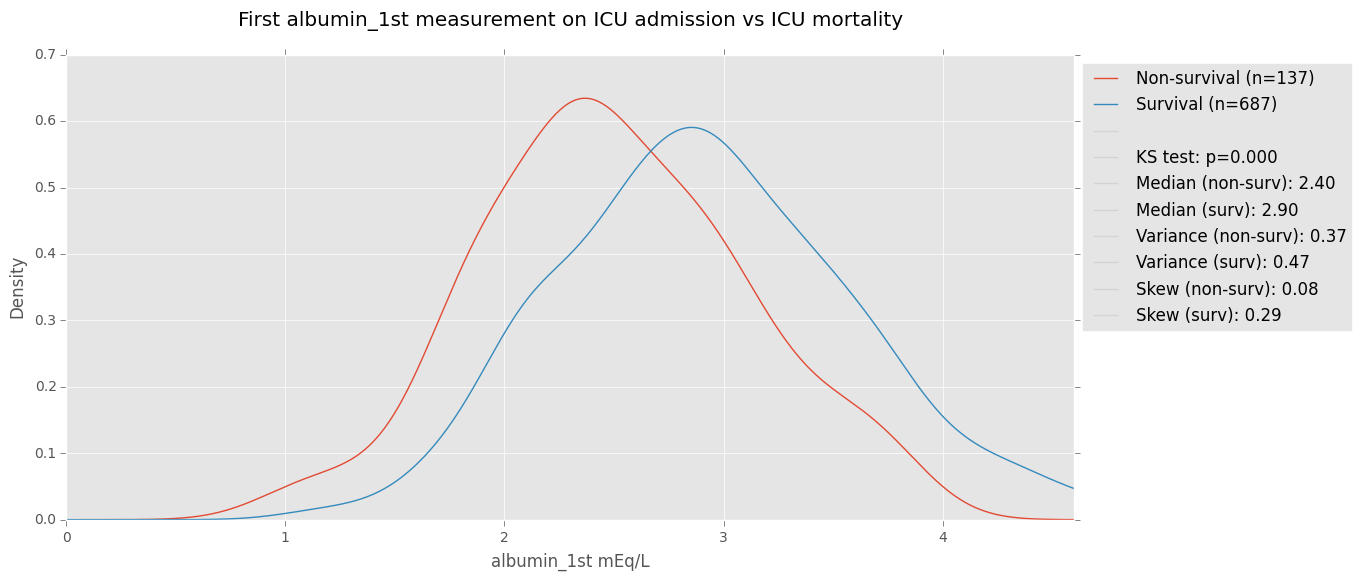

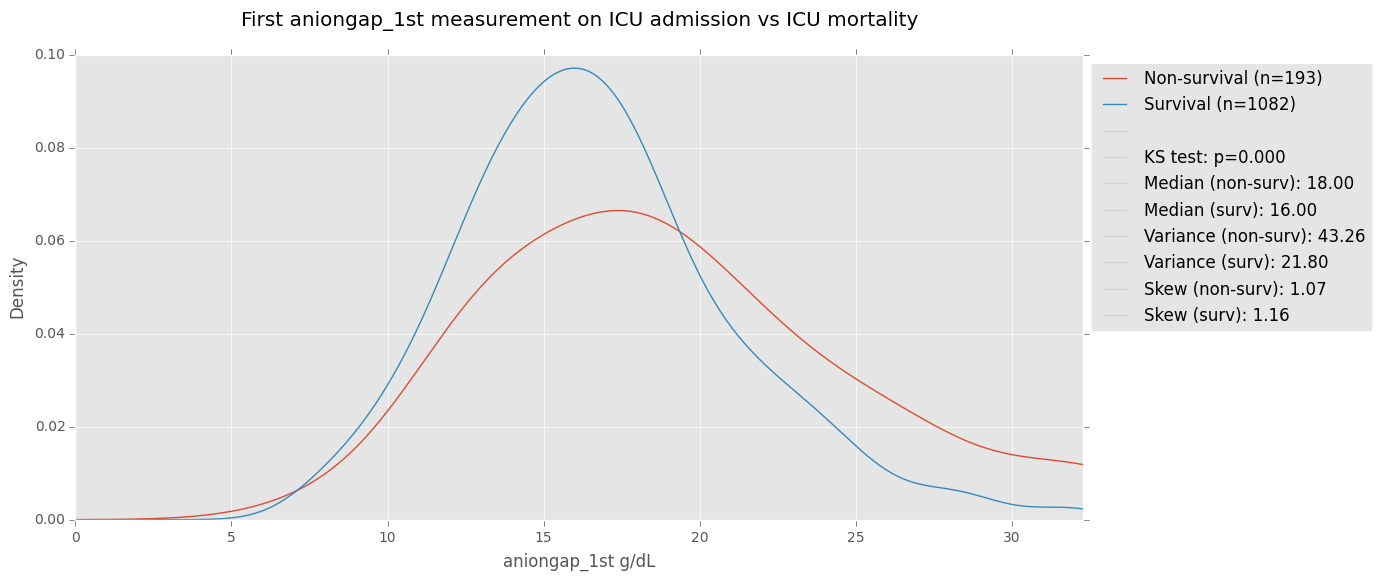

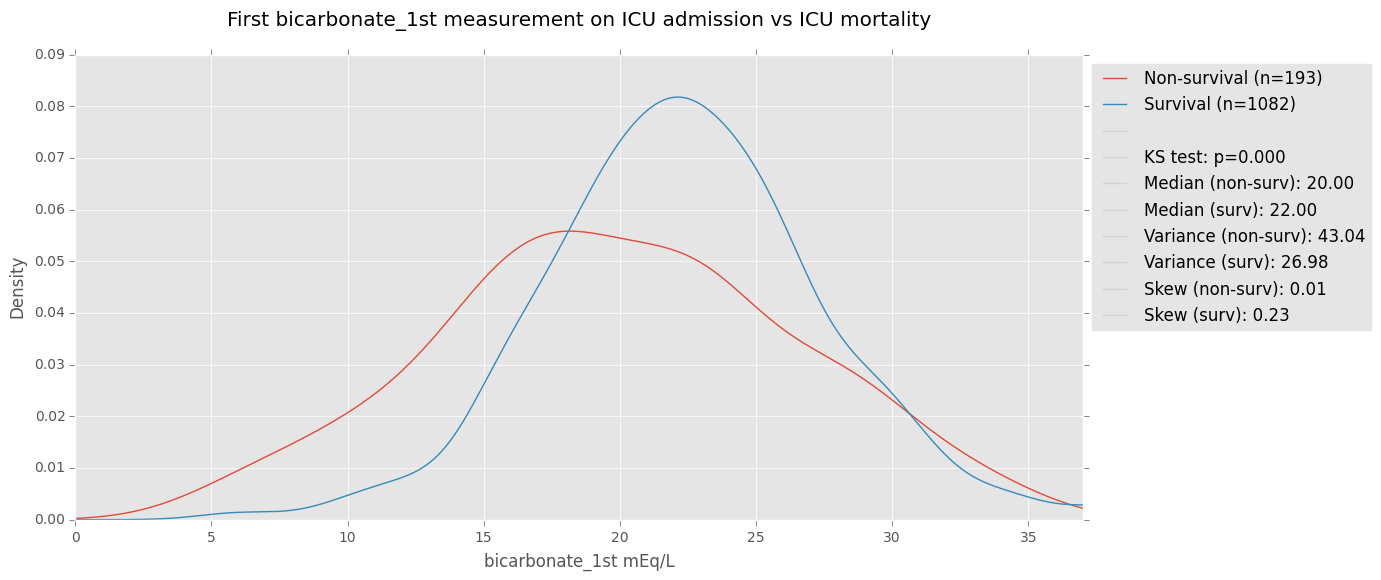

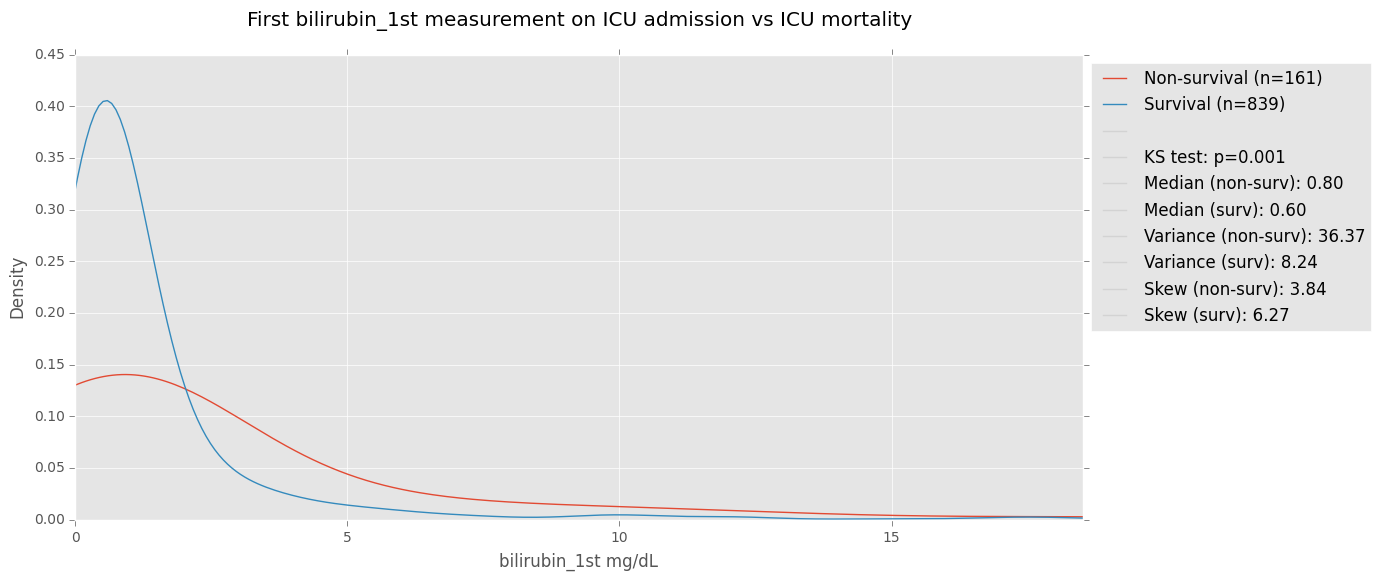

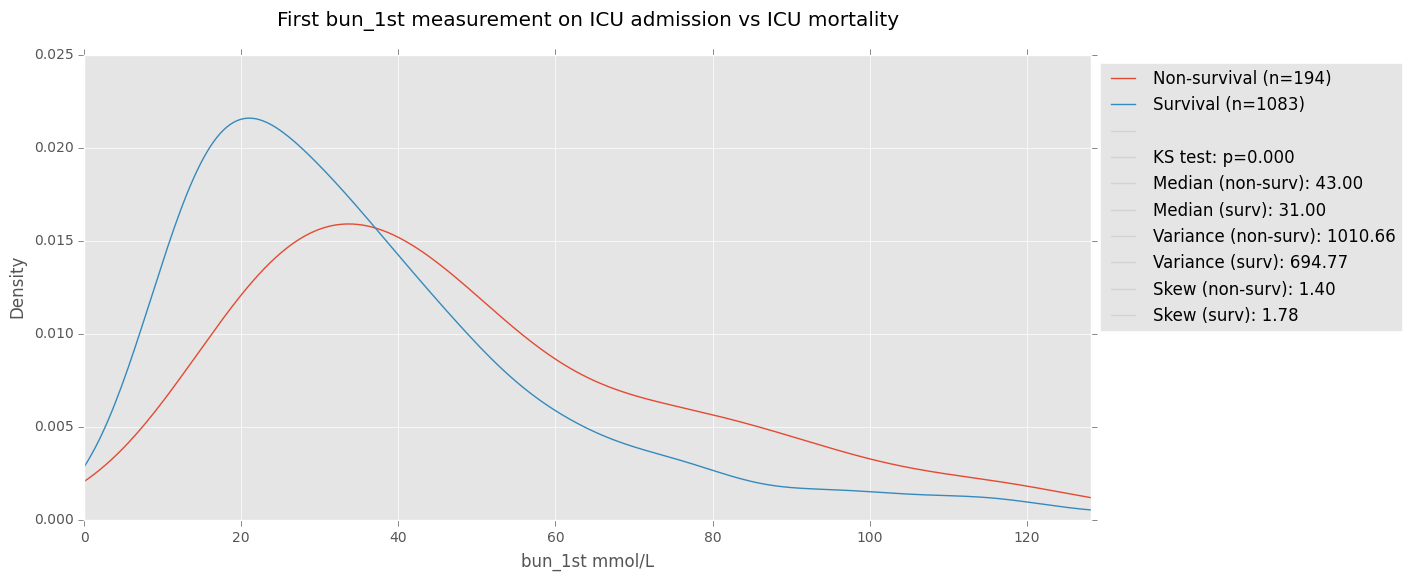

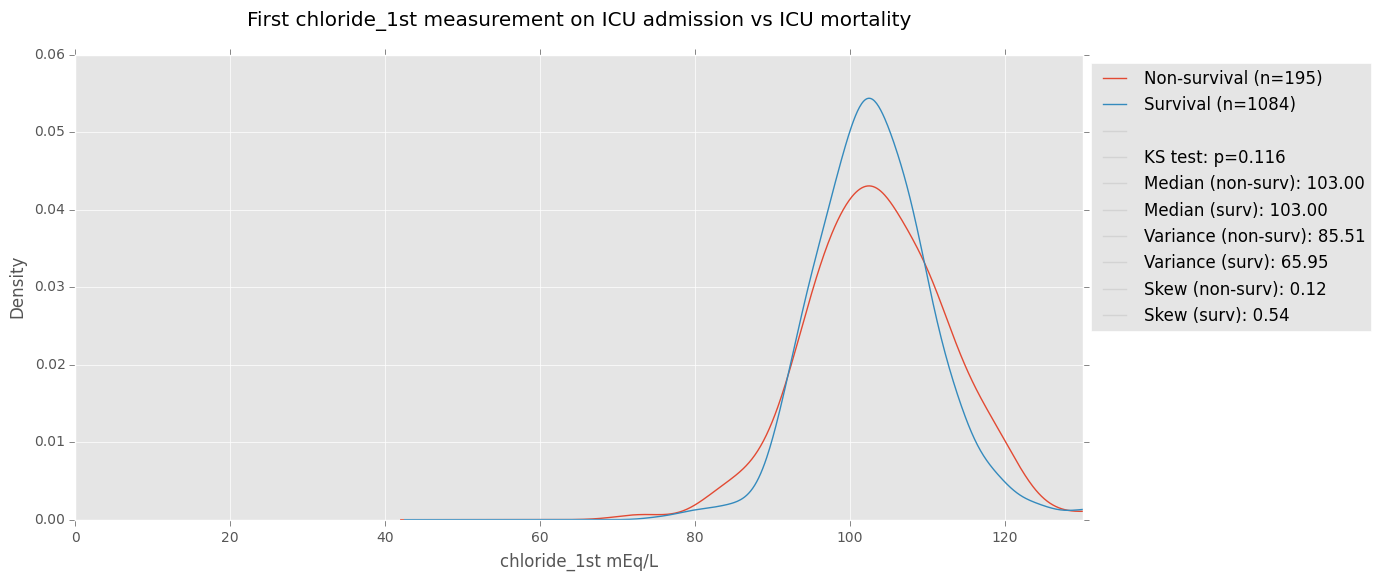

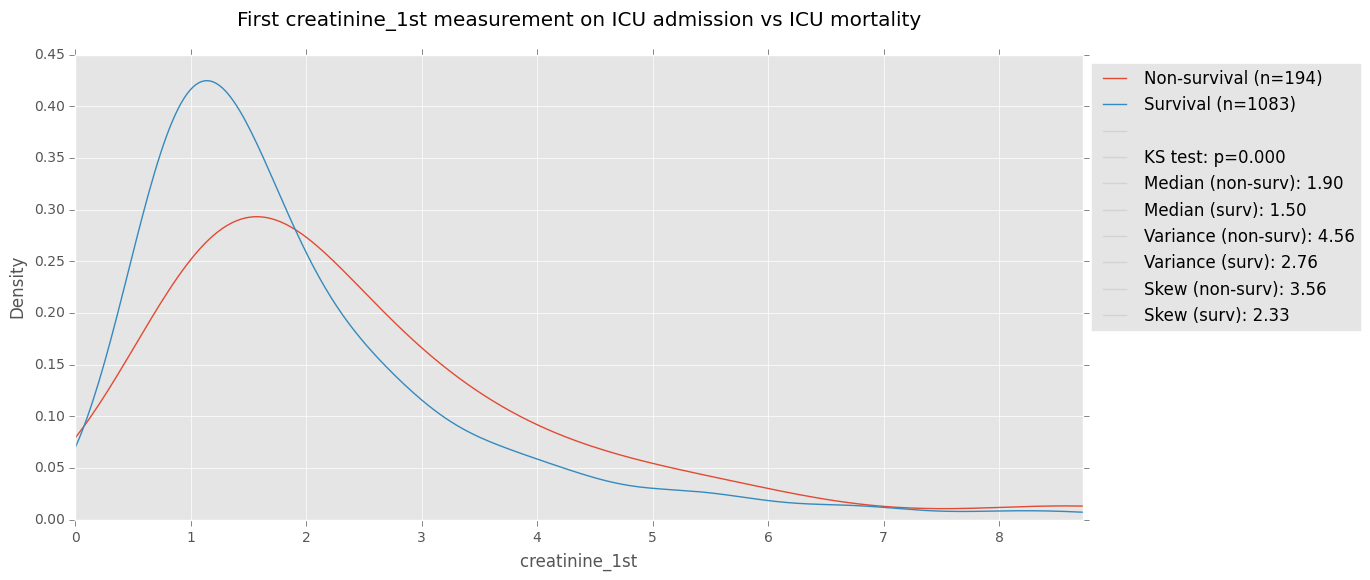

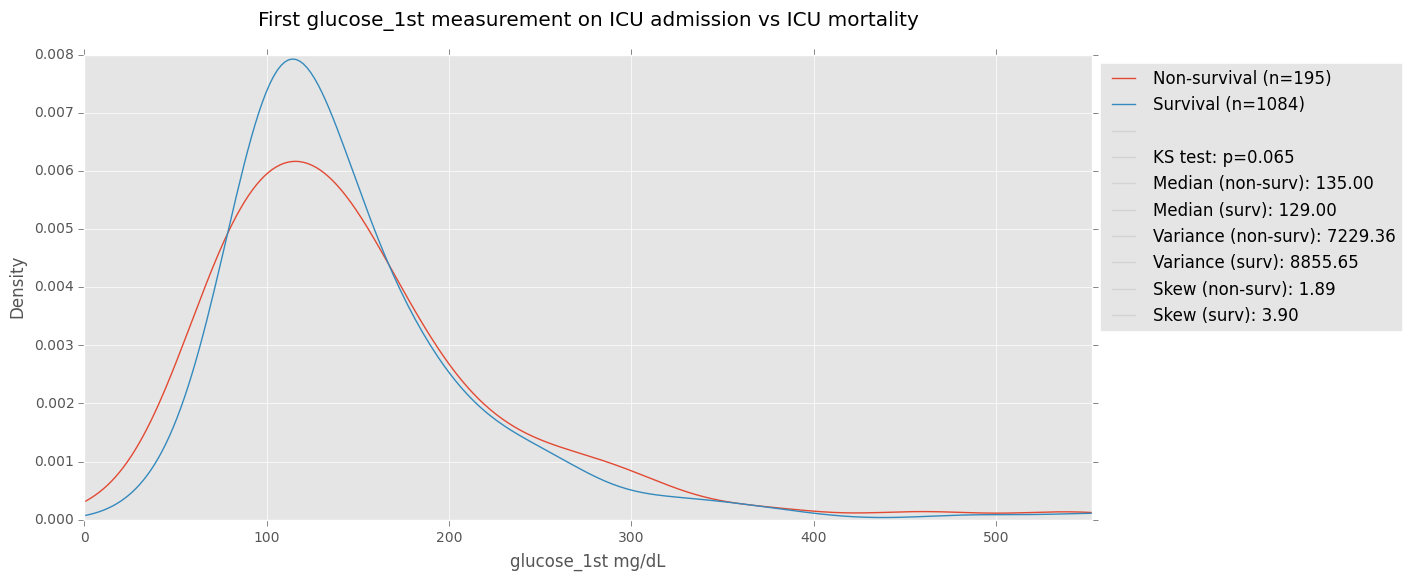

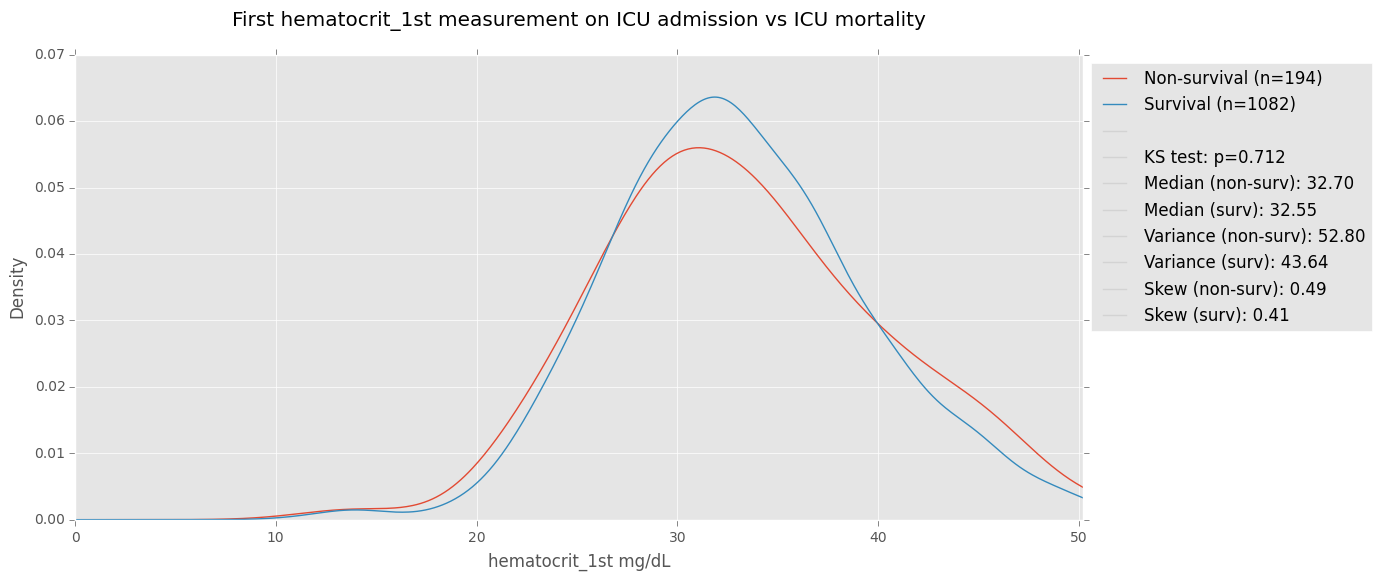

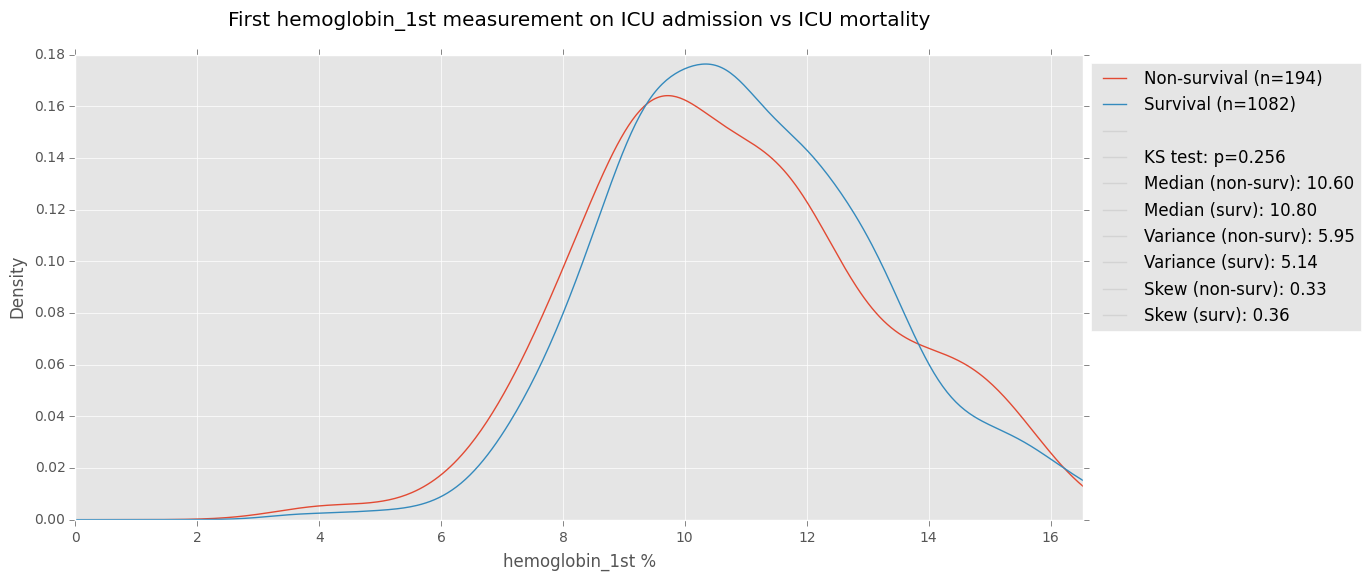

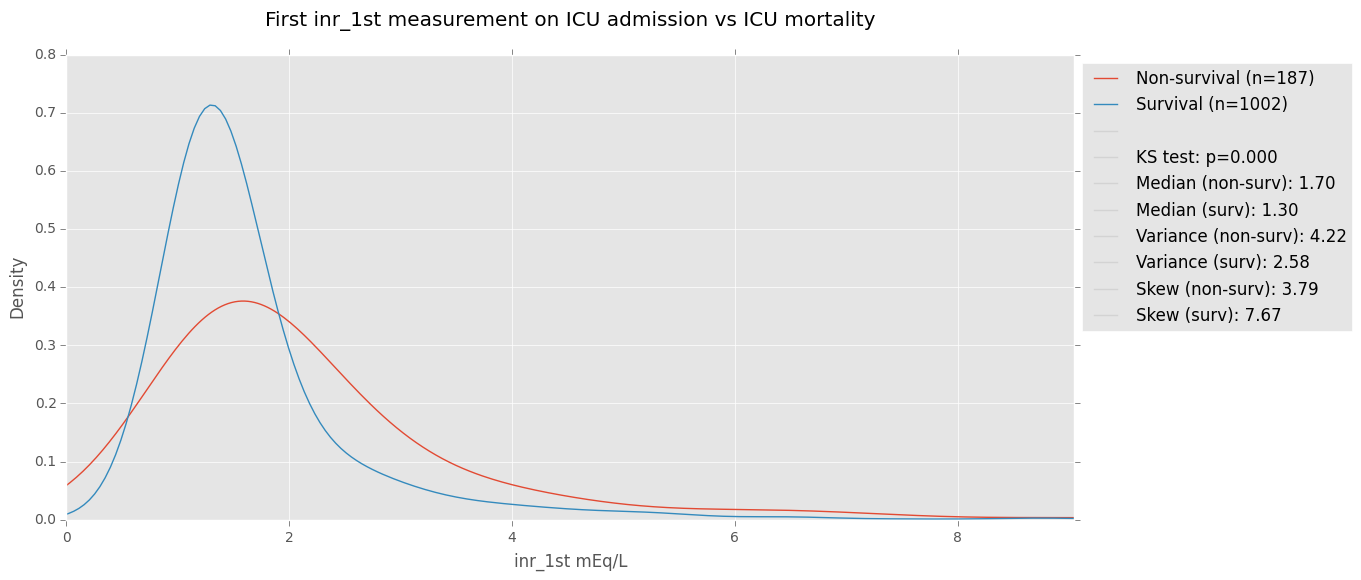

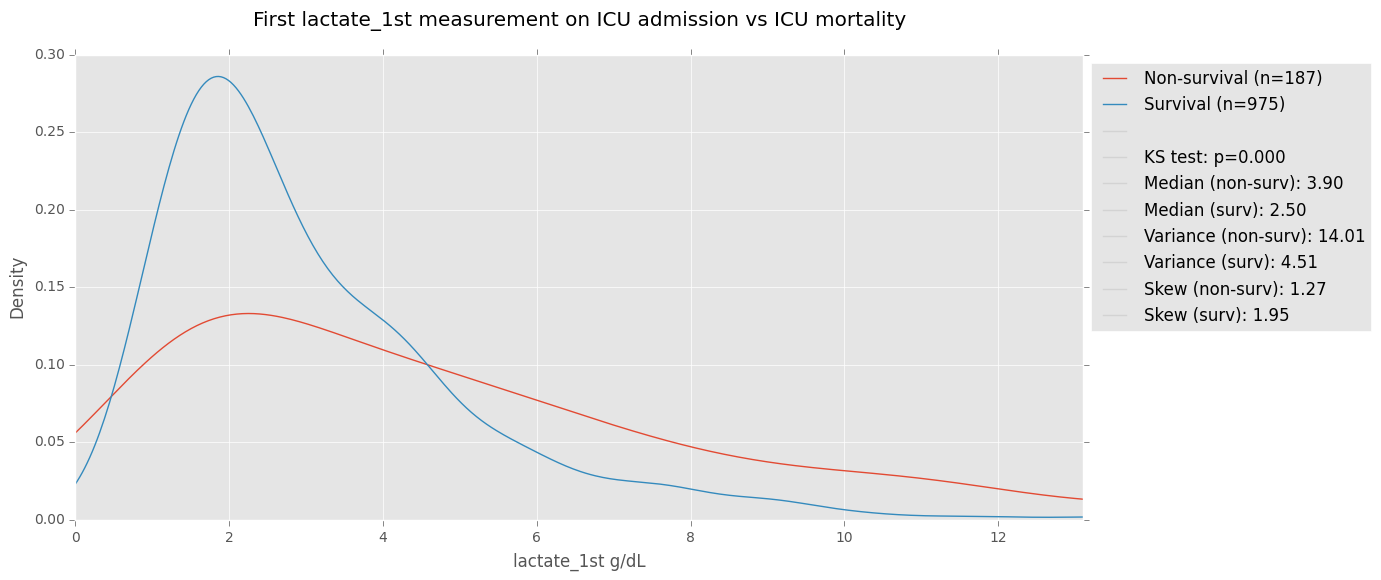

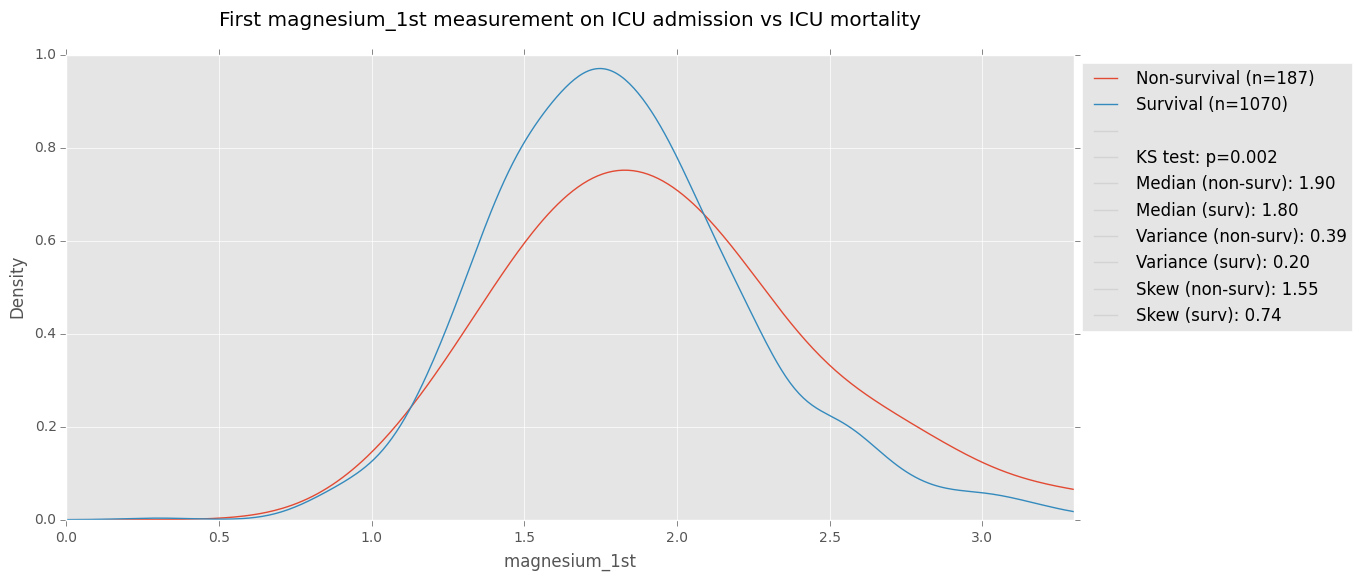

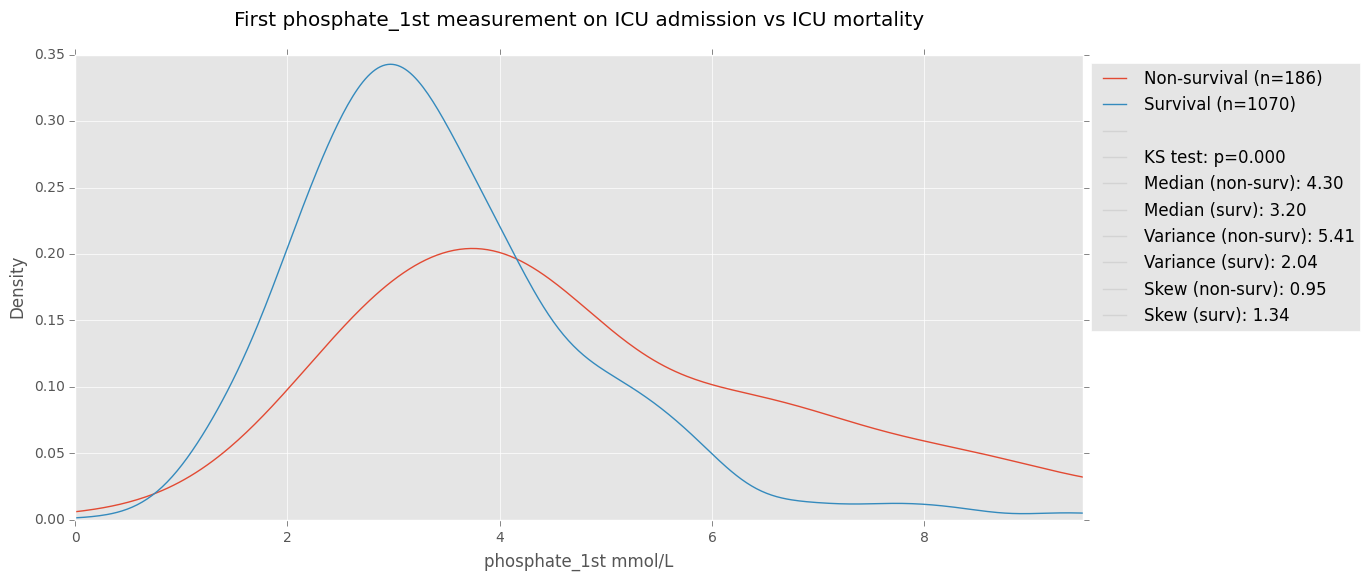

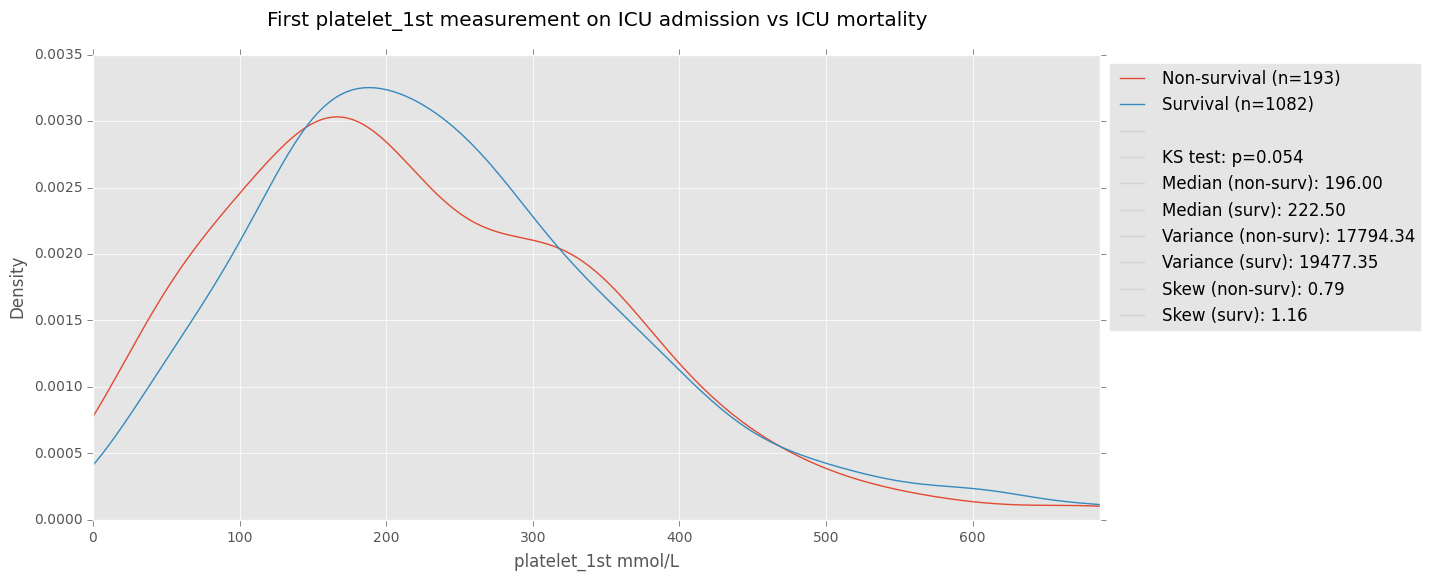

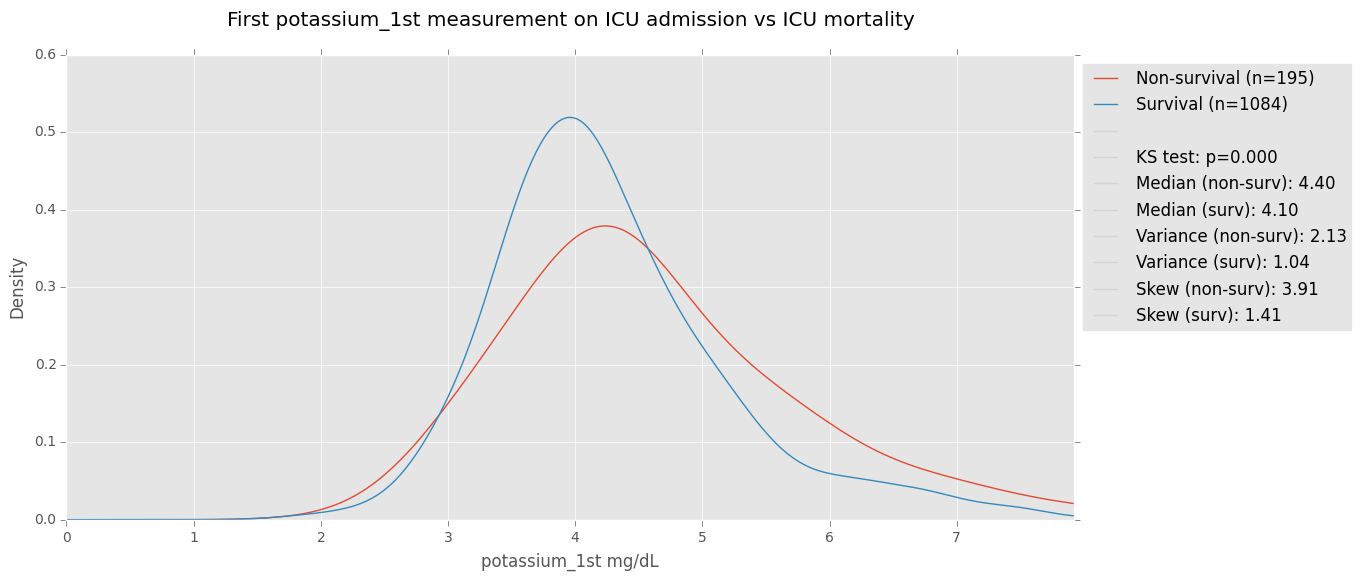

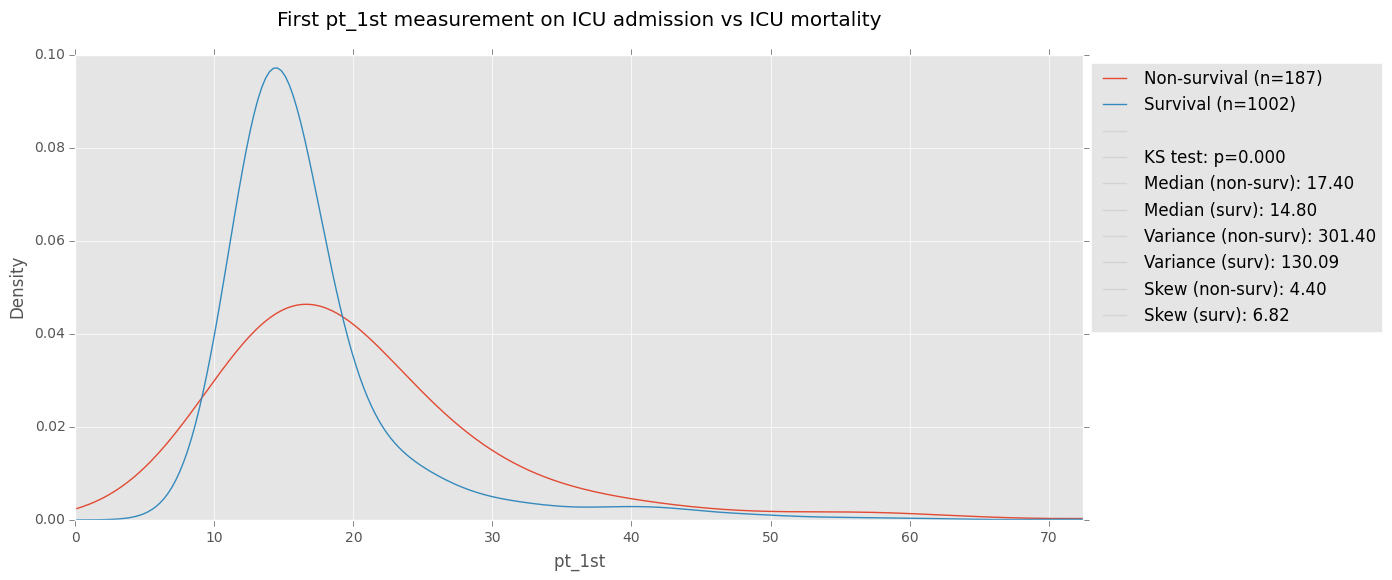

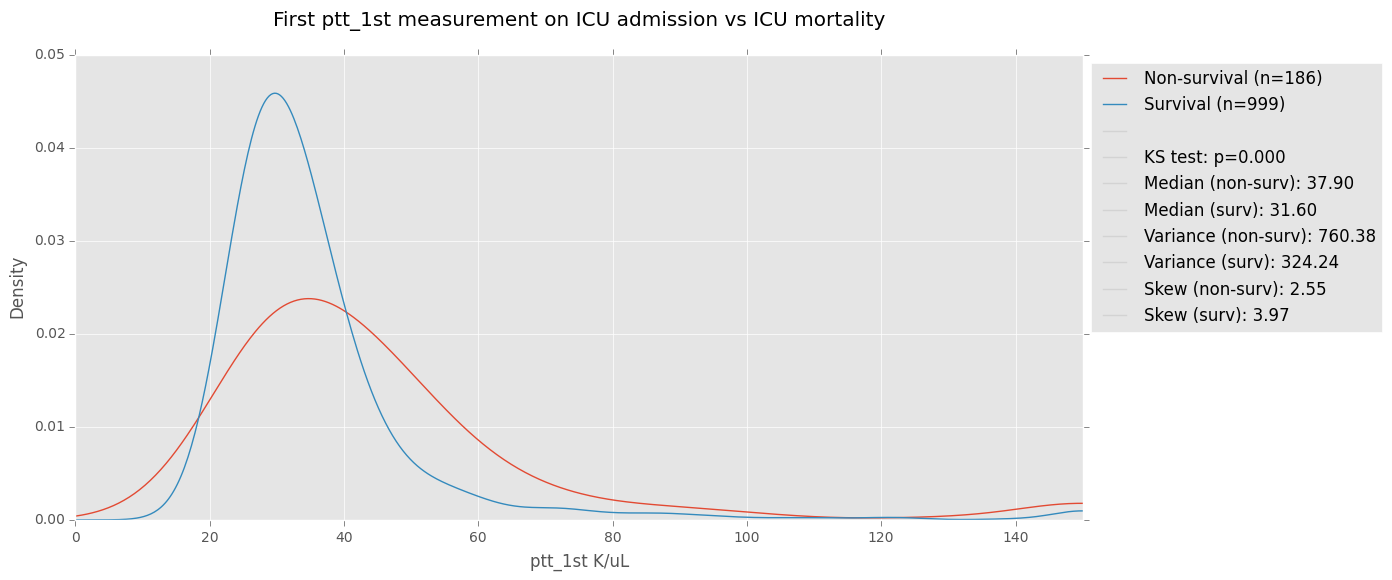

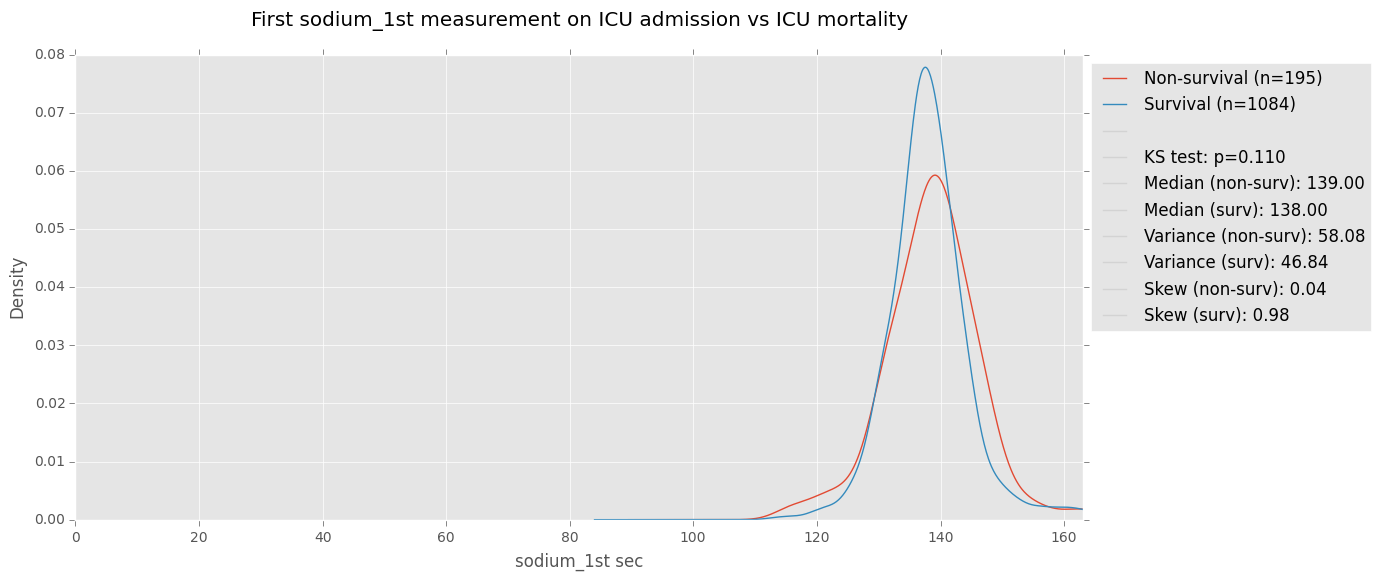

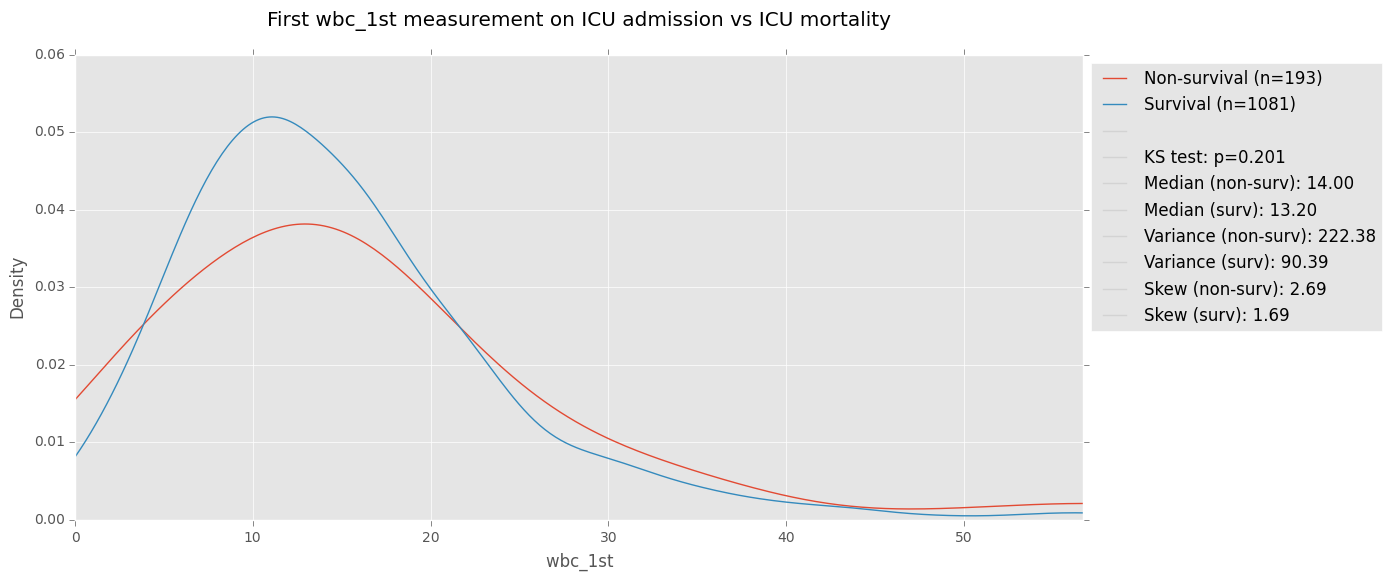

In [31]:
for l, u in iter(sorted(labs_dict.iteritems())):
    # count patients
    n_nonsurv = data[l][data.mort_icu==1].dropna().count()
    n_surv = data[l][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l][data.mort_icu==1].dropna().median()
    med_surv = data[l][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l][data.mort_icu==1].dropna().var()
    var_surv = data[l][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l][data.mort_icu==1].dropna().skew()
    skew_surv = data[l][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l][data.mort_icu==1].dropna(),
                              data[l][data.mort_icu==0].dropna())

    # plot
    plt.subplots(figsize=(13,6))
    data[l][data.mort_icu==1].dropna().plot.kde(
        alpha=1.0,label='Non-survival (n={})'.format(n_nonsurv))
    data[l][data.mort_icu==0].dropna().plot.kde(
        alpha=1.0,label='Survival (n={})'.format(n_surv))
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')

    # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
    plt.xlim(0, data[l].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')

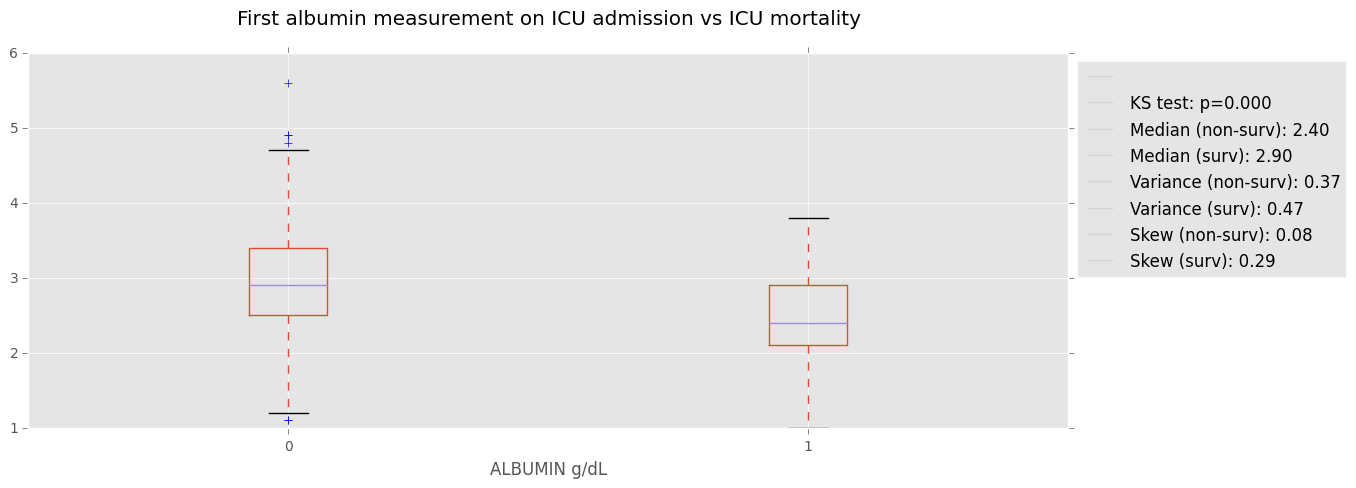

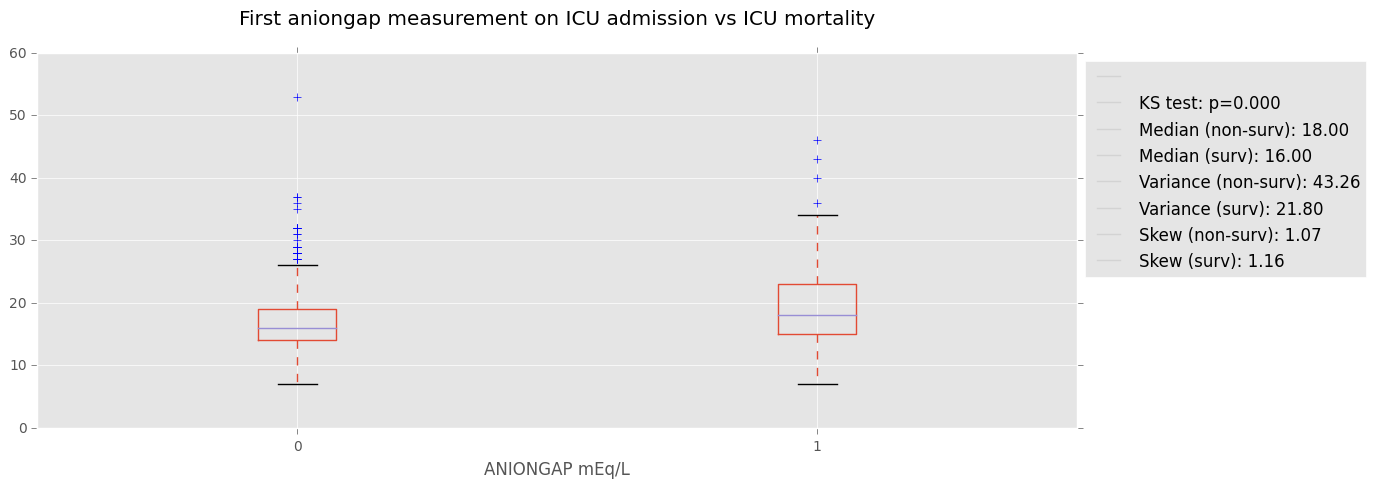

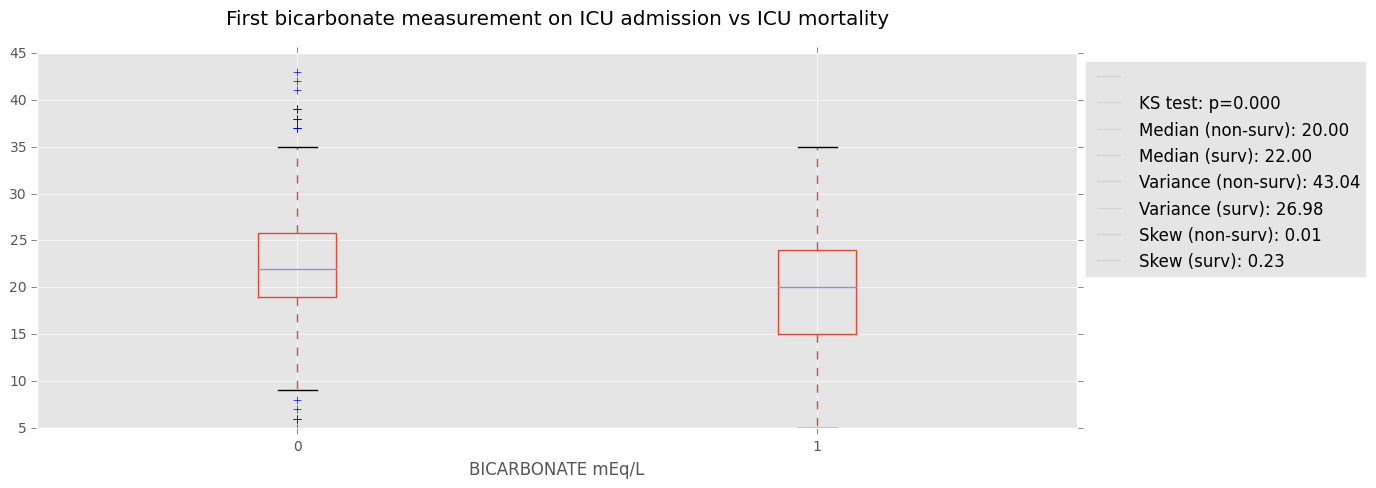

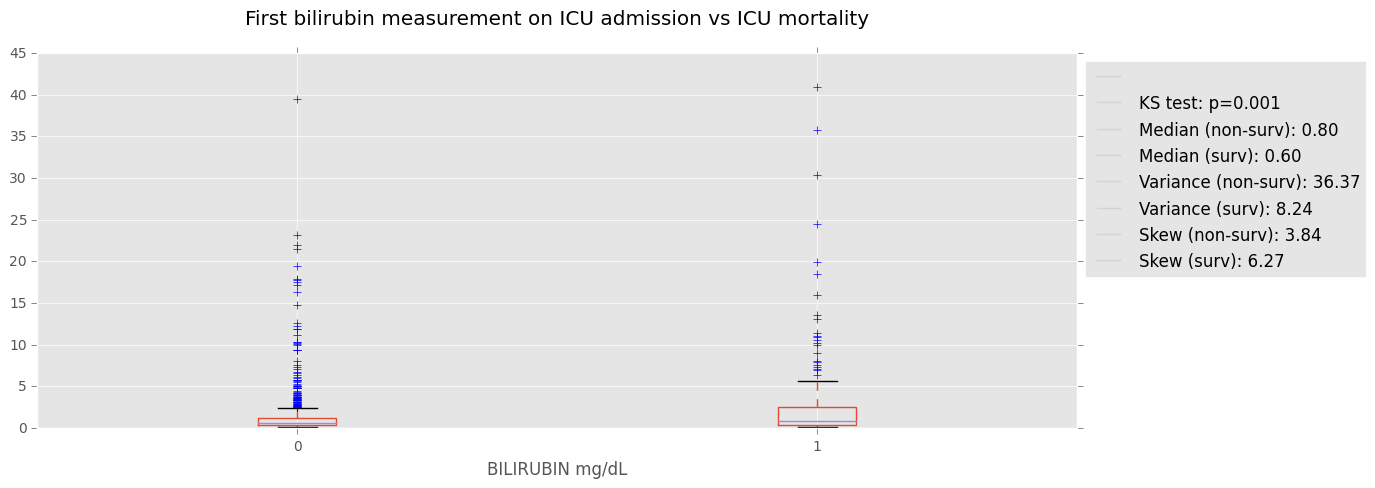

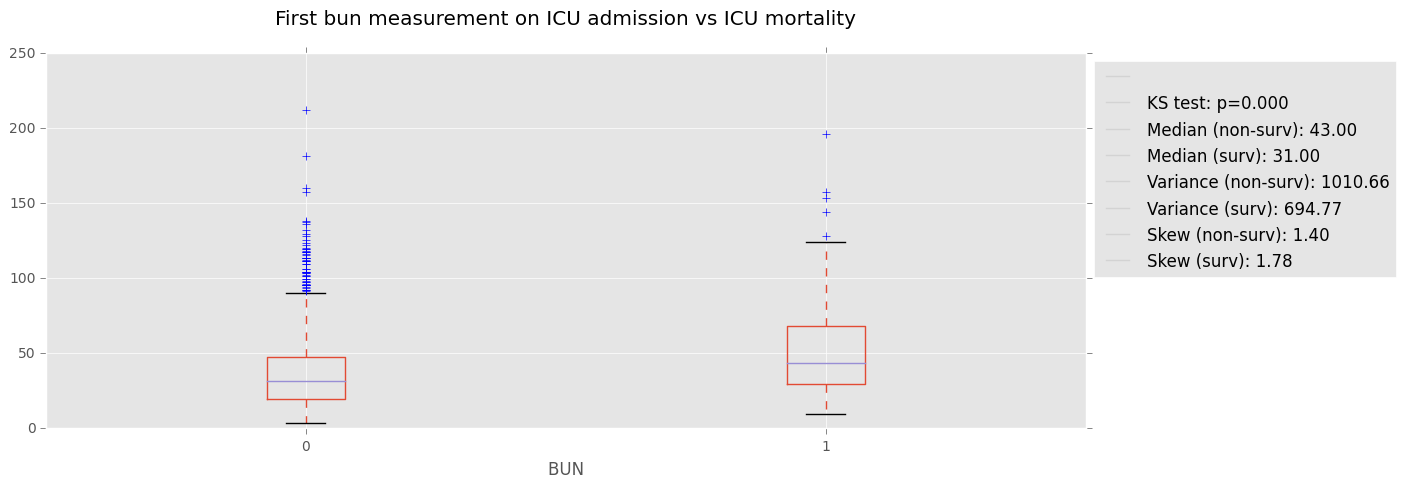

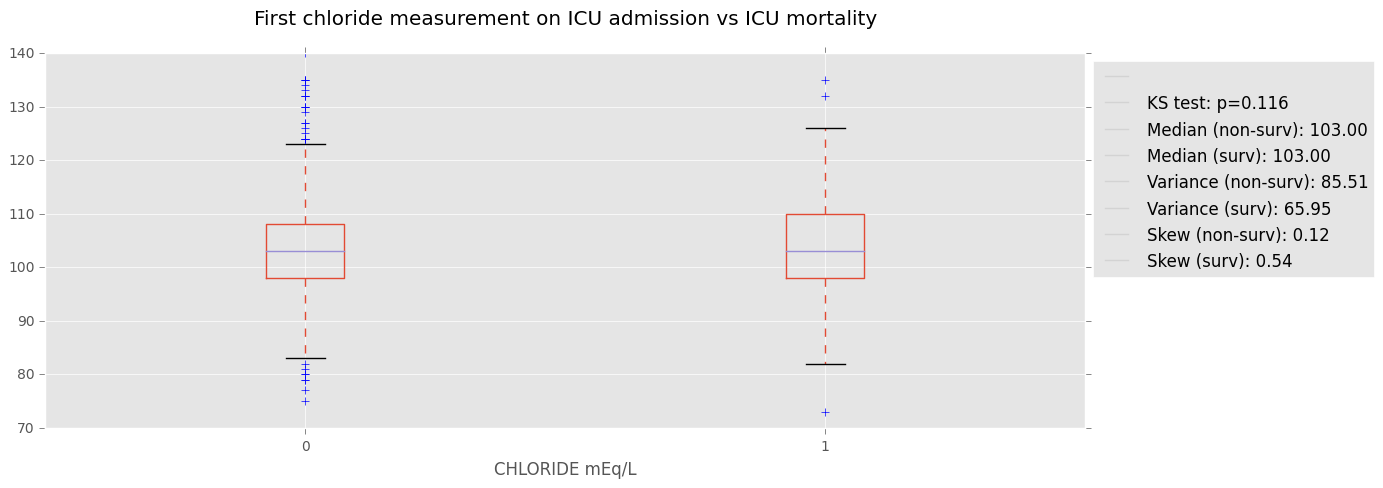

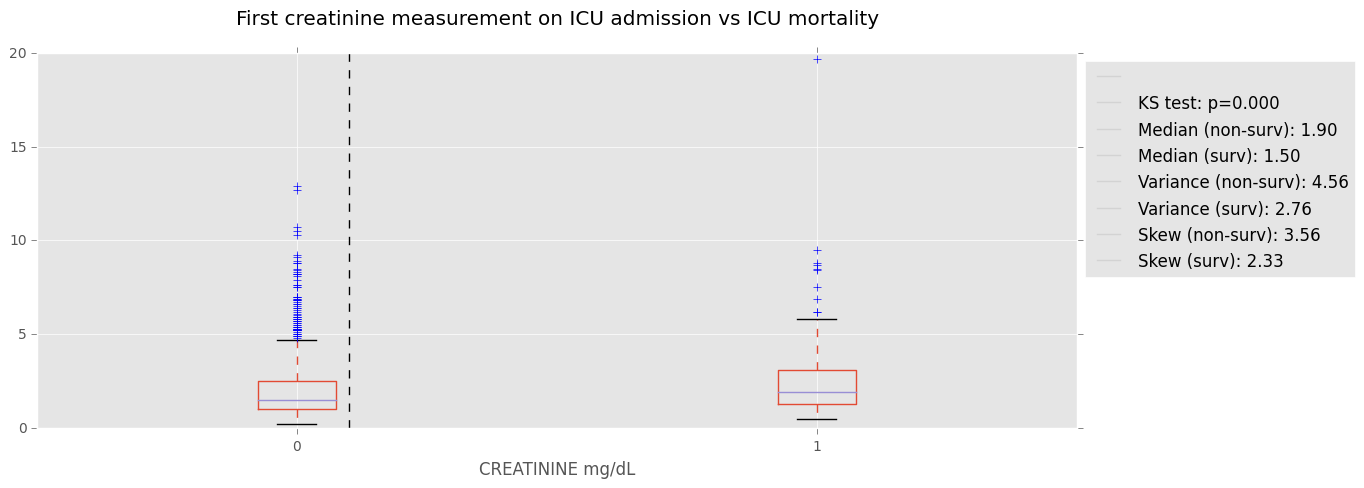

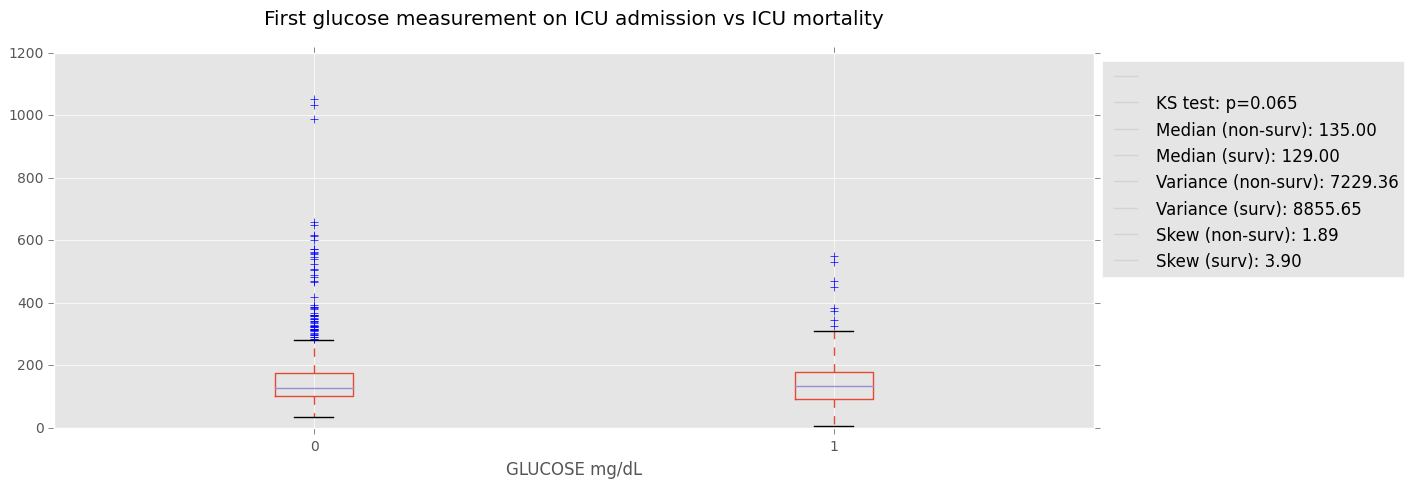

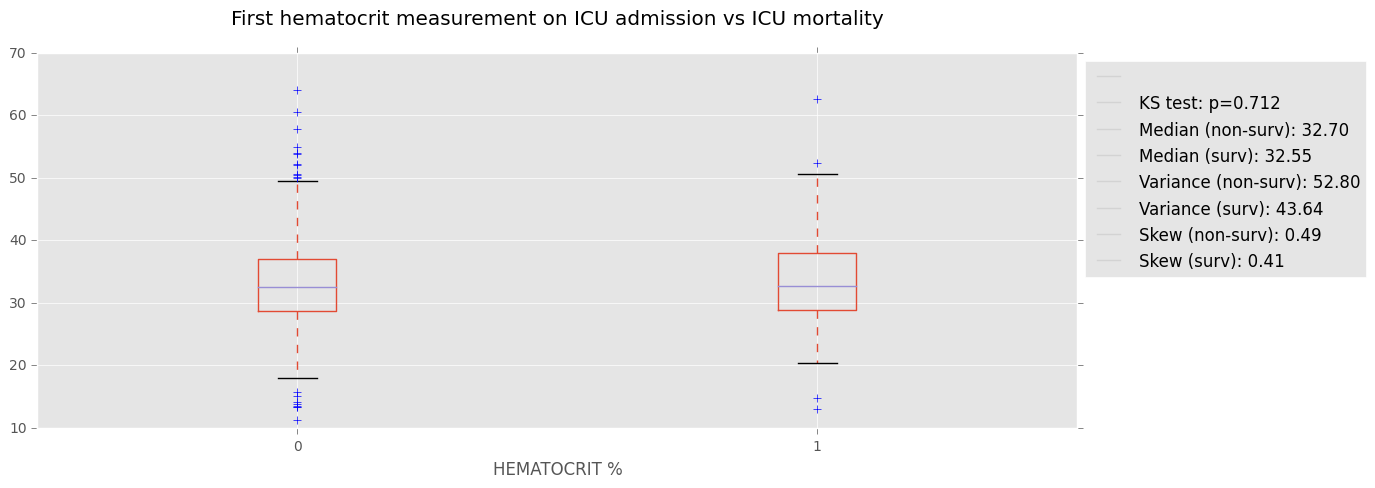

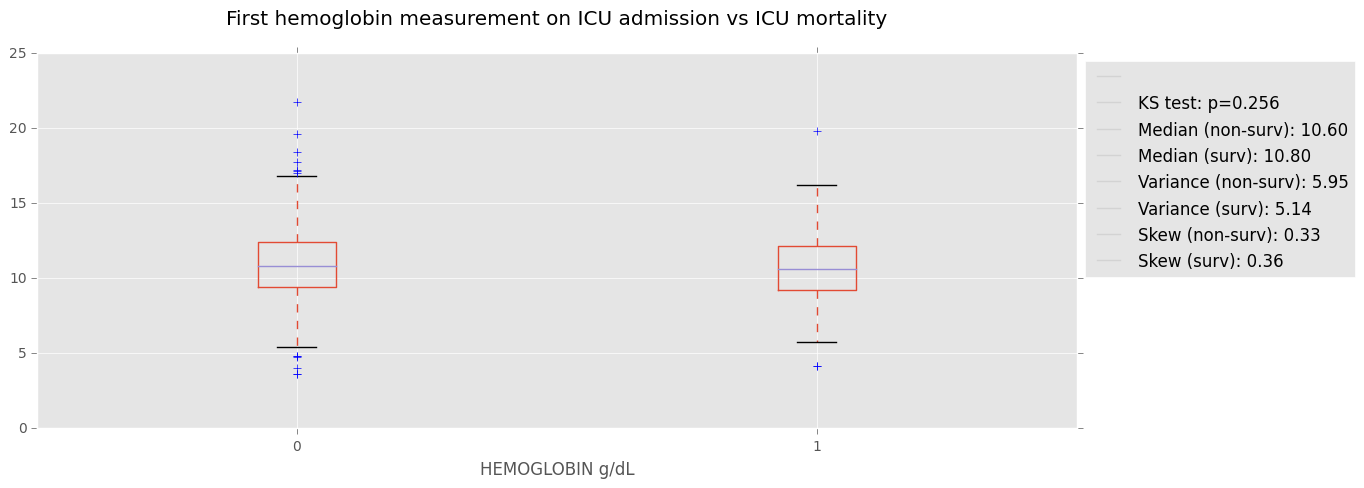

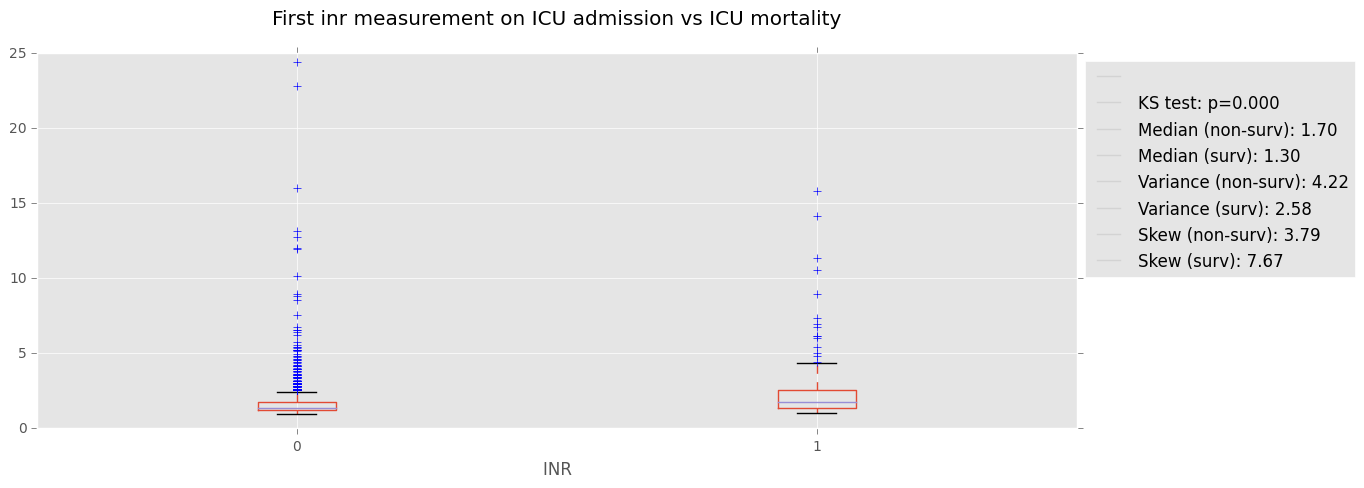

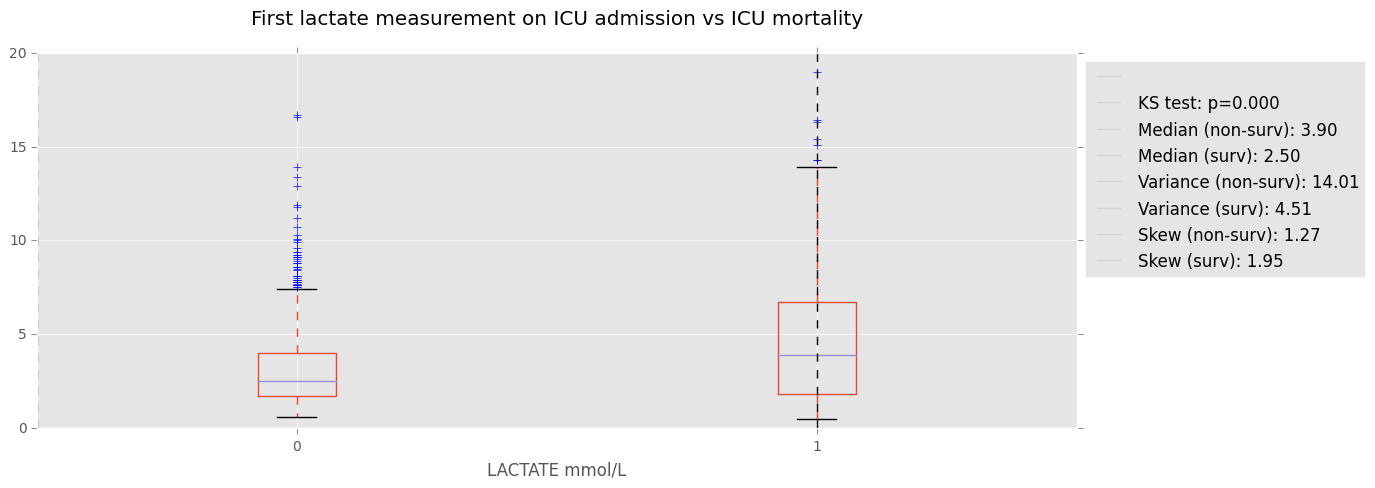

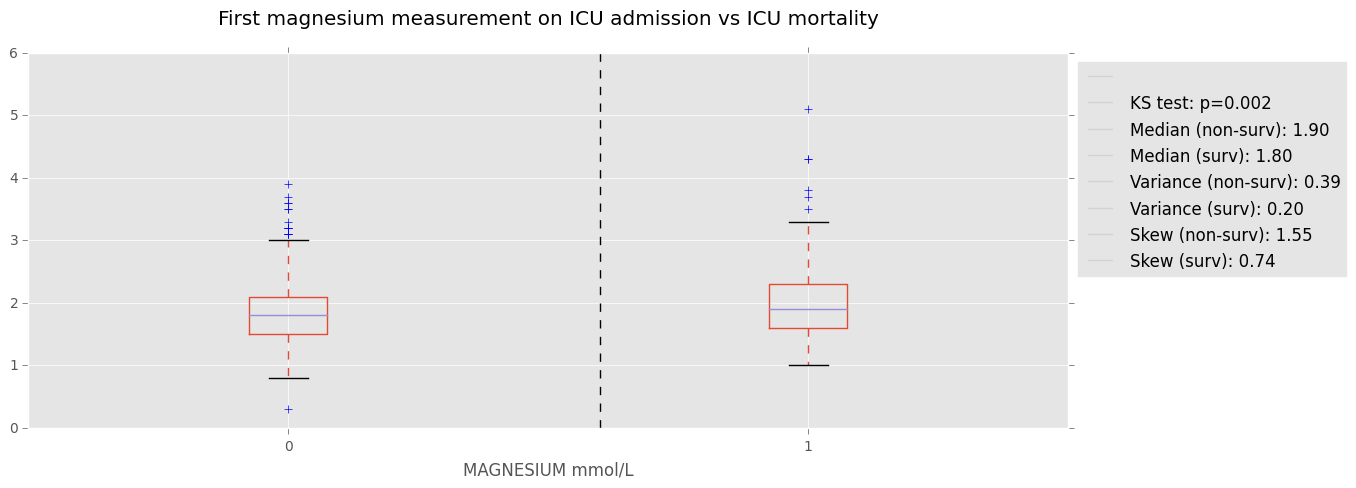

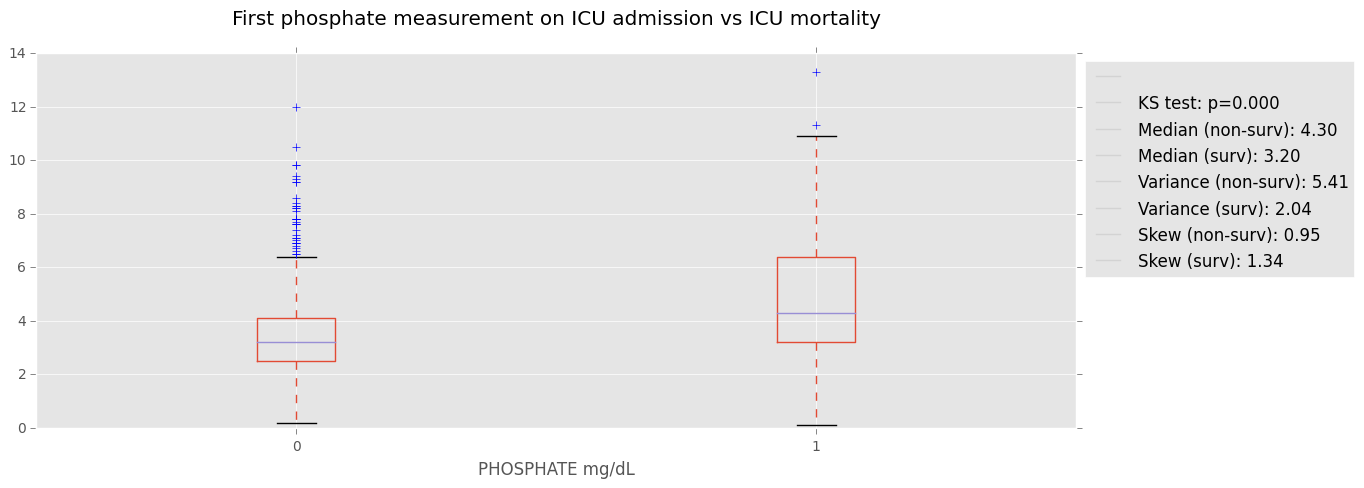

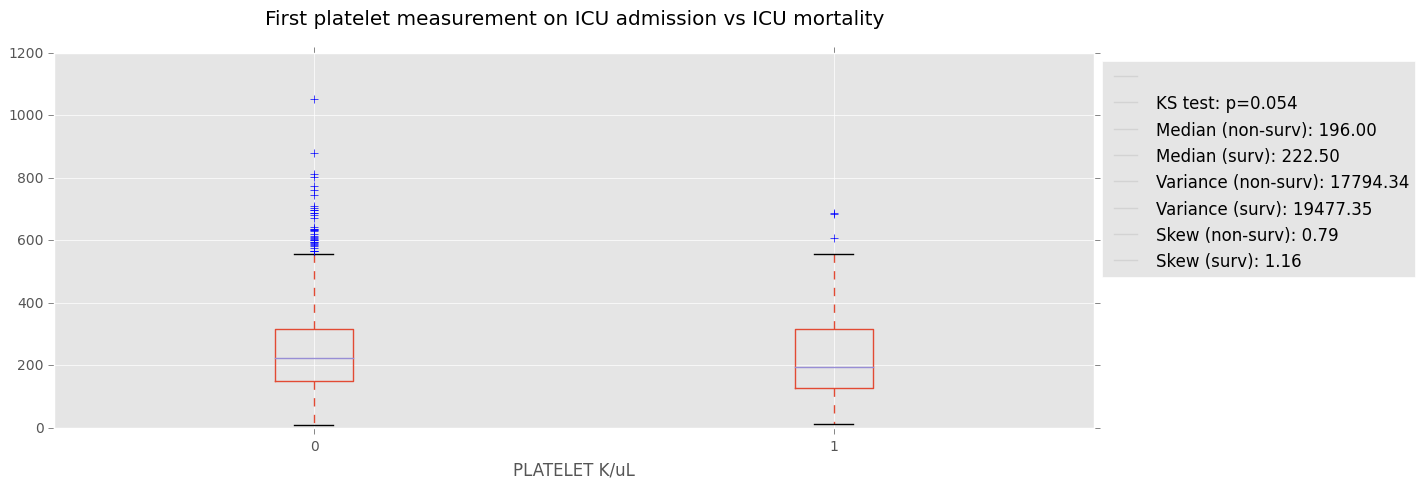

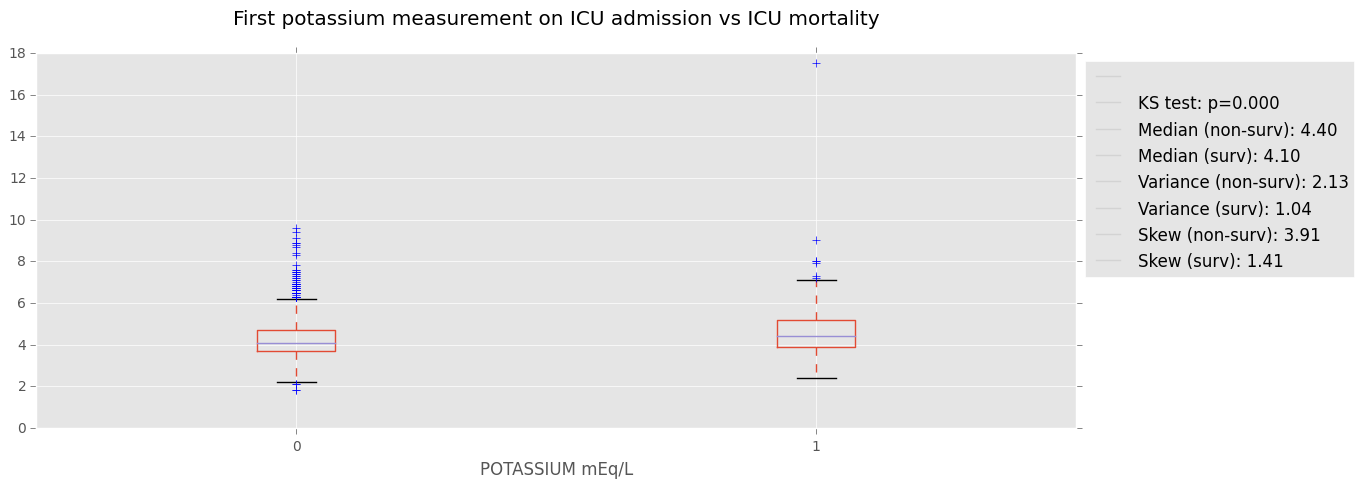

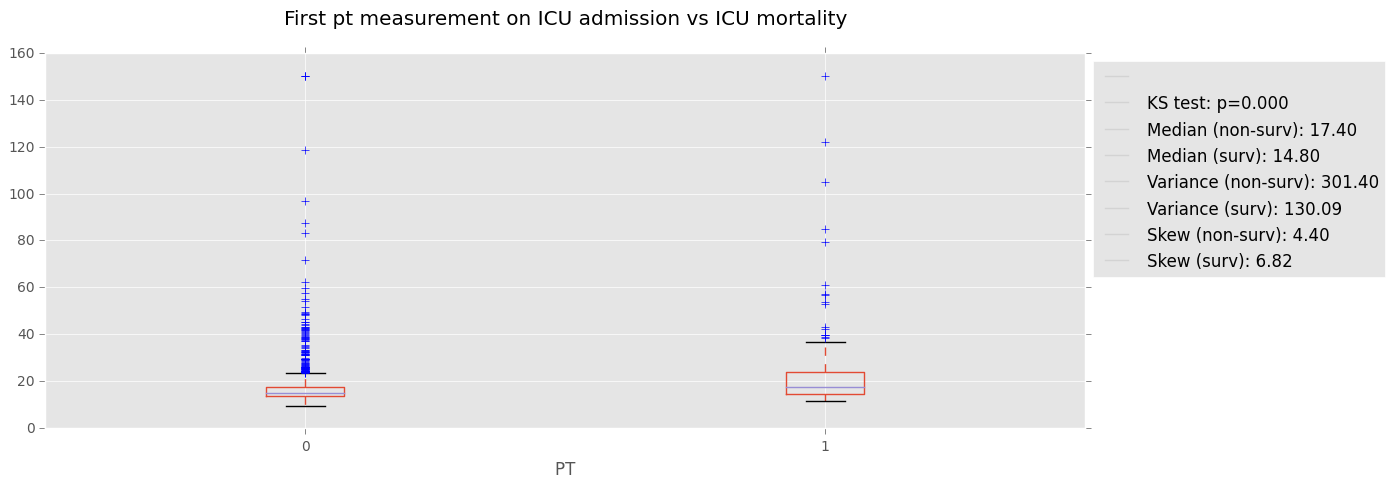

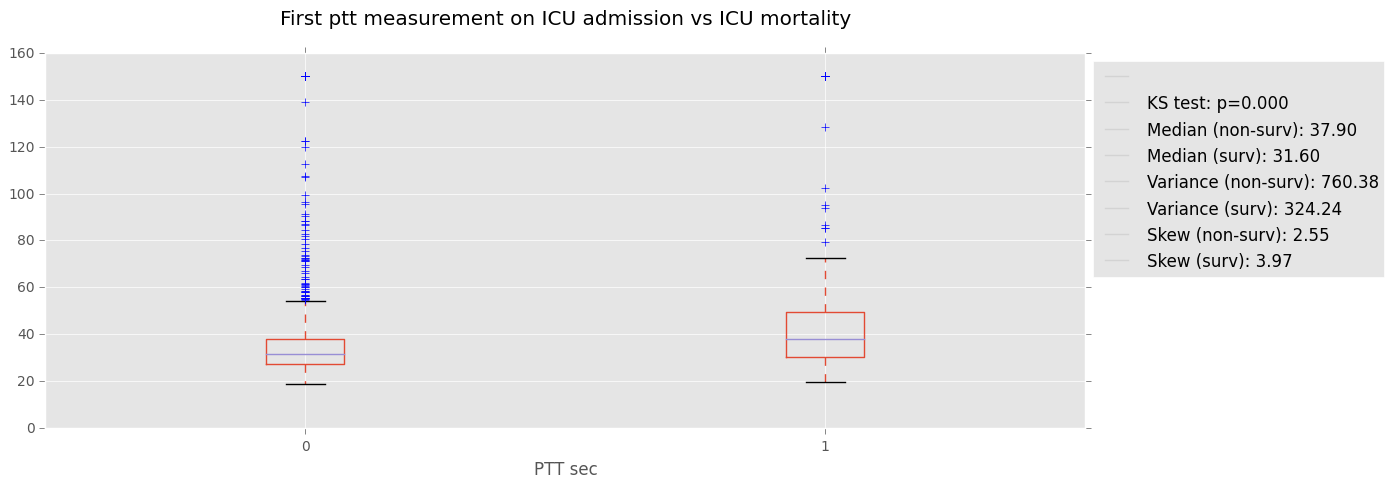

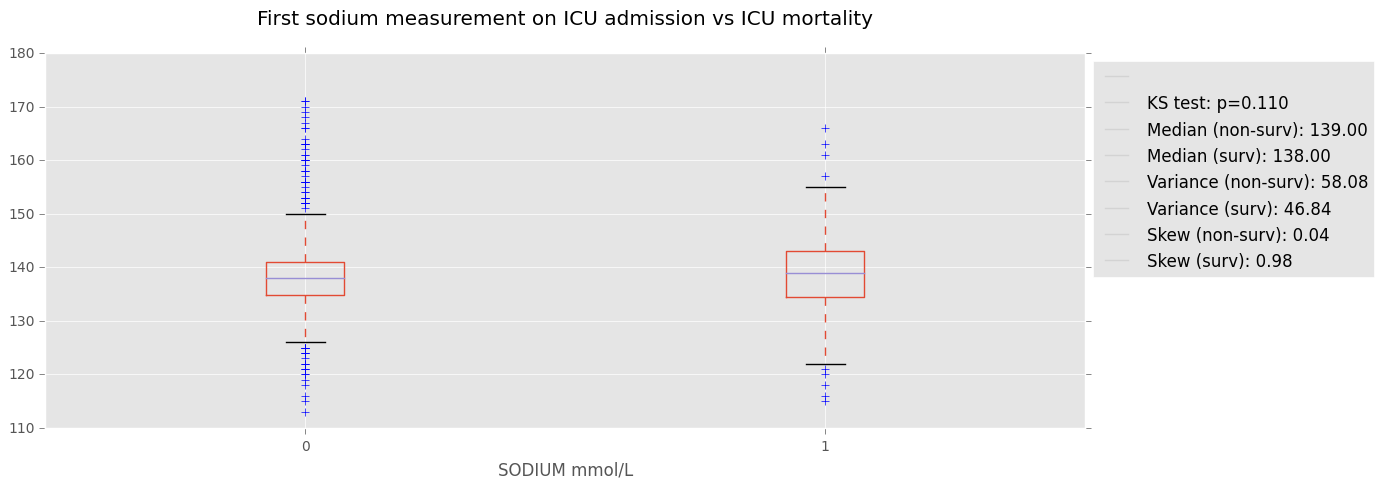

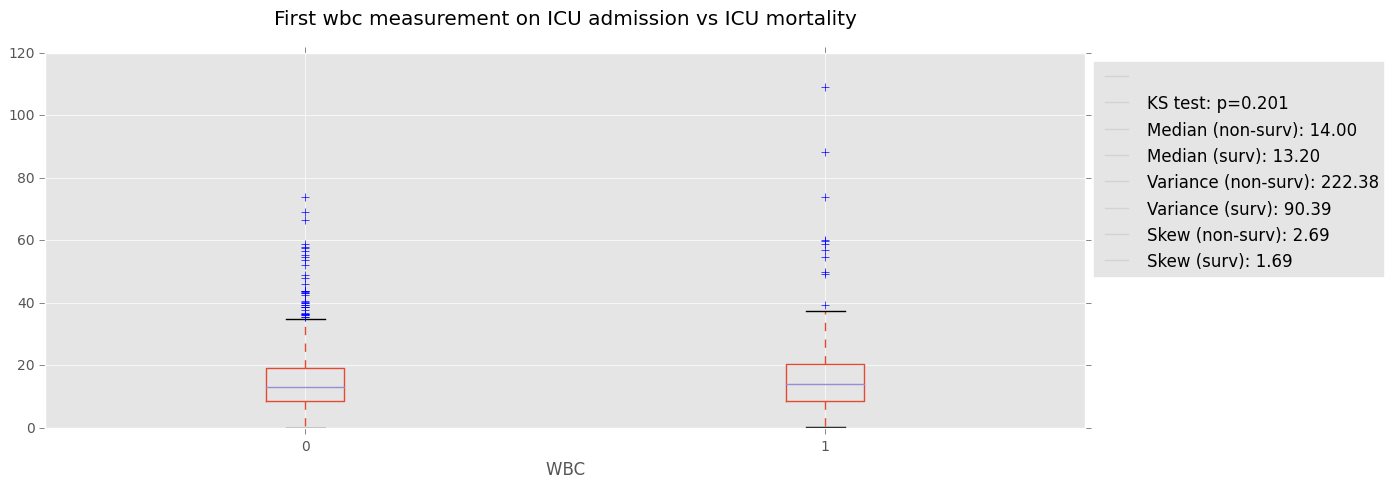

In [66]:
# Plot first laboratory measurement on ICU admission vs ICU mortality
# Would be clearer to plot CDF
# Additional variables to be added: magnesium, phosphate, calcium

labs = {'ANIONGAP': 'mEq/L',
        'ALBUMIN': 'g/dL',
        'BICARBONATE': 'mEq/L',
        'BILIRUBIN': 'mg/dL',
        'BUN': '',
        'CHLORIDE': 'mEq/L',
        'CREATININE': 'mg/dL',
        'GLUCOSE': 'mg/dL',
        'HEMATOCRIT': '%',
        'HEMOGLOBIN': 'g/dL',
        'INR': '',
        'LACTATE': 'mmol/L',
        'MAGNESIUM': 'mmol/L',
        'PHOSPHATE': 'mg/dL',
        'PLATELET': 'K/uL',
        'POTASSIUM': 'mEq/L',
        'PT': '',
        'PTT': 'sec',
        'SODIUM':'mmol/L',
        'WBC': ''}

for l, u in iter(sorted(labs.iteritems())):
    # count patients
    n_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().count()
    n_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().count()
    
    # get median, variance, skewness
    med_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().median()
    med_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().median()
    var_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().var()
    var_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().var()
    skew_nonsurv = data[l.lower()+'_1st'][data.mort_icu==1].dropna().skew()
    skew_surv = data[l.lower()+'_1st'][data.mort_icu==0].dropna().skew() 
    
    # Are the 2 samples drawn from the same continuous distribution? 
    # Try Kolmogorov Smirnov test 
    ks_stat, p_val = ks_2samp(data[l.lower()+'_1st'][data.mort_icu==1].dropna(),
                              data[l.lower()+'_1st'][data.mort_icu==0].dropna())

    # plot
    #fig, ax1 = plt.subplots(figsize=(13, 6))
    #fig.canvas.set_window_title('A Boxplot Example')
    #plt.subplots(figsize=(13,6))
    #box_data = data[['mort_icu', l.lower()+'_1st']].dropna()
    data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
   #data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))
    #    label='Non-survival (n={})'.format(n_nonsurv))
    plt.suptitle("")
    '''
    data[l.lower()+'_1st'][data.mort_icu==0].dropna().plot.box(
        label='Survival (n={})'.format(n_surv))
    '''
    
    # fake plots for KS test, median, etc
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='KS test: p={}'.format(format(p_val,'.3f')),
             color='lightgray')
    plt.plot([], label='Median (non-surv): {}'.format(format(med_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Median (surv): {}'.format(format(med_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (non-surv): {}'.format(format(var_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Variance (surv): {}'.format(format(var_surv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (non-surv): {}'.format(format(skew_nonsurv,'.2f')),
             color='lightgray')
    plt.plot([], label='Skew (surv): {}'.format(format(skew_surv,'.2f')),
             color='lightgray')
    
   # add title, labels etc.
    plt.title('First {} measurement on ICU admission '.format(l.lower()) +
               'vs ICU mortality \n')
    
    plt.xlabel(l + ' ' + u)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
   # plt.xlim(0, data[l.lower()+'_1st'].dropna().quantile(0.99))
    
    # Add lab range if available
    if l in lab_ranges:
        plt.axvline(lab_ranges[l][0],color='k',linestyle='--')
        plt.axvline(lab_ranges[l][1],color='k',linestyle='--')
    
    